In [2]:
import pandas as pd
import numpy as np

In [3]:
gsdp_data_cleaned = {
    'Year': [
        2011, 2012, 2013, 2014, 2015, 2016,
        2017, 2018, 2019, 2020, 2021, 2022
    ],
    'Current': [
        343798, 391388, 443960, 494803, 550804, 616085,
        677900, 738389, 792911, 763435, 904642, 1043759
    ],
    'Constant_2011_12': [
        343798, 366628, 392908, 428355, 475623, 511765,
        542015, 565327, 586168, 547682, 597765, 652649
    ]
}
pd.DataFrame(gsdp_data_cleaned)

,Year,Current,Constant_2011_12
0,2011,343798,343798
1,2012,391388,366628
2,2013,443960,392908
3,2014,494803,428355
4,2015,550804,475623
5,2016,616085,511765
6,2017,677900,542015
7,2018,738389,565327
8,2019,792911,586168
9,2020,763435,547682


In [4]:
import os
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from skimage.feature import graycomatrix, graycoprops

###########################################
# 1. Prepare Monthly SDP Data via Interpolation
###########################################

# Annual SDP data (note: values taken from your gsdp_data_cleaned, renamed to SDP)
sdp_data = {
    'Year': [2011, 2012, 2013, 2014, 2015, 2016,
             2017, 2018, 2019, 2020, 2021, 2022],
    'SDP': [343798, 391388, 443960, 494803, 550804, 616085,
            677900, 738389, 792911, 763435, 904642, 1043759]
}
sdp_df = pd.DataFrame(sdp_data)
# Create a date column for January of each year
sdp_df['date'] = pd.to_datetime(sdp_df['Year'].astype(str) + '-01-01')
sdp_df = sdp_df.set_index('date')

# Build a monthly date range from the start of 2011 up to January 2024
monthly_dates = pd.date_range(
    start=sdp_df.index.min(), end='2024-01-01', freq='MS')
# Reindex and linearly interpolate the SDP values to monthly frequency
monthly_sdp = sdp_df.reindex(monthly_dates).interpolate(method='linear')
monthly_sdp = monthly_sdp.reset_index().rename(columns={'index': 'date'})

# Add year and month columns (will be used for merging later)
monthly_sdp['year'] = monthly_sdp['date'].dt.year
monthly_sdp['month'] = monthly_sdp['date'].dt.month

###########################################
# 2. Feature Extraction from TIFF Images
###########################################


def extract_features_from_tif(image_path):
    """Extract summary features from a .tif image, handling NaN values."""
    with rasterio.open(image_path) as src:
        img = src.read(1)

    # If the image is a masked array, fill masked values with 0
    if np.ma.is_masked(img):
        img = img.filled(fill_value=0)

    # Replace any NaNs with 0
    img = np.nan_to_num(img, nan=0)

    # Compute basic statistics using functions that ignore NaNs (or after replacing them)
    light_sum = np.nansum(img)
    light_mean = np.nanmean(img)
    light_std = np.nanstd(img)
    light_max = np.nanmax(img)

    # Urban area ratio: proportion of pixels above a threshold (e.g. 30)
    threshold = 30
    urban_area_ratio = (img > threshold).sum() / img.size
    brightness_urban = light_mean * urban_area_ratio

    # Calculate entropy from the histogram
    hist, _ = np.histogram(img.astype(np.uint8), bins=256, range=(0, 256))
    if hist.sum() > 0:
        hist = hist / hist.sum()
    non_zero = hist[hist > 0]
    entropy = -np.sum(non_zero * np.log2(non_zero)) if non_zero.size > 0 else 0

    # Texture features using Gray-Level Co-occurrence Matrix (GLCM)
    img_uint8 = img.astype(np.uint8)
    # Prevent issues with an all-zero image
    if img_uint8.max() == 0:
        img_uint8[0, 0] = 1
    glcm = graycomatrix(img_uint8, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]

    return {
        'light_sum': light_sum,
        'light_mean': light_mean,
        'light_std': light_std,
        'light_max': light_max,
        'urban_area_ratio': urban_area_ratio,
        'brightness_urban': brightness_urban,
        'light_entropy': entropy,
        'light_contrast': contrast,
        'light_energy': energy
    }


def process_images(image_dir):
    """
    Process all images in the given directory.
    Expects filenames in the format: 
      "Delhi_VIIRS_NTL_YYYY_MM.tif"
    """
    features_list = []
    for fname in os.listdir(image_dir):
        if fname.endswith('.tif'):
            parts = fname.split('_')
            # Expected parts: ["Delhi", "VIIRS", "NTL", "YYYY", "MM.tif"]
            if len(parts) >= 5:
                try:
                    year = int(parts[3])
                    month = int(parts[4].split('.')[0])
                except ValueError:
                    continue  # skip files that don't match the format
                image_path = os.path.join(image_dir, fname)
                feats = extract_features_from_tif(image_path)
                feats['year'] = year
                feats['month'] = month
                # Create a date (using day=1 for convenience)
                feats['date'] = pd.Timestamp(year=year, month=month, day=1)
                feats['image_path'] = image_path
                features_list.append(feats)
    return pd.DataFrame(features_list)


# Set your directory containing the TIFF images
image_dir = "./Delhi_Nighttime_Lights"  # adjust path as needed
features_df = process_images(image_dir)

In [5]:
# After processing the images and creating features_df
import pickle

# Save the features DataFrame to a pickle file
with open('delhi_nightlights_features.pkl', 'wb') as f:
    pickle.dump(features_df, f)

print(f"Features DataFrame saved with {len(features_df)} records.")

Features DataFrame saved with 149 records.


In [ ]:

###########################################
# 3. Merge Image Features with Monthly SDP Data
###########################################

# Merge on year and month to assign a monthly SDP value to each image's features
merged_df = pd.merge(features_df, monthly_sdp, on=[
                     'year', 'month'], how='inner')
# Example: Add month as a feature (encoded as integer or one-hot)
merged_df['month_int'] = merged_df['month']

# Now merged_df contains the extracted features and the corresponding 'SDP' target
merged_df

,light_sum,light_mean,light_std,light_max,urban_area_ratio,brightness_urban,light_entropy,light_contrast,light_energy,year,month,date_x,image_path,date_y,Year,SDP,month_int
0,282239.750000,18.501459,18.952574,198.742859,0.255588,4.728757,5.445753,20.235966,0.128461,2022,7,2022-07-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2022_...,2022-07-01,2022.000000,1.043759e+06,7
1,407545.500000,26.715536,29.788198,210.221054,0.346050,9.244924,5.896276,81.314886,0.118026,2014,12,2014-12-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2014_...,2014-12-01,2014.916667,5.461372e+05,12
2,264128.500000,17.314224,19.845497,147.800003,0.226614,3.923650,5.315820,29.787941,0.161055,2014,6,2014-06-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2014_...,2014-06-01,2014.416667,5.181368e+05,6
3,357408.250000,23.428925,25.881641,167.628571,0.317273,7.433366,5.743537,48.561022,0.127259,2016,3,2016-03-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2016_...,2016-03-01,2016.166667,6.263875e+05,3
4,255626.734375,16.756914,18.100279,155.250000,0.223992,3.753417,5.305254,28.917844,0.147228,2018,6,2018-06-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2018_...,2018-06-01,2018.416667,7.611065e+05,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,314072.968750,20.588198,24.881002,200.581818,0.278138,5.726367,5.488308,50.664443,0.151124,2013,1,2013-01-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2013_...,2013-01-01,2013.000000,4.439600e+05,1
134,279702.687500,18.335148,20.796299,148.500000,0.239528,4.391782,5.398069,29.615110,0.157374,2014,8,2014-08-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2014_...,2014-08-01,2014.583333,5.274702e+05,8
135,305173.000000,20.004786,20.055862,237.466660,0.279777,5.596881,5.550257,27.293554,0.113213,2022,9,2022-09-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2022_...,2022-09-01,2022.000000,1.043759e+06,9
136,338998.500000,22.222124,26.859234,210.259262,0.292363,6.496930,5.582665,60.784639,0.143029,2013,3,2013-03-01,./Delhi_Nighttime_Lights/Delhi_VIIRS_NTL_2013_...,2013-03-01,2013.166667,4.524338e+05,3


Insufficient data for test date 2012-08-01. Skipping.
Test date 2012-09-01: Predicted SDP = 422055.00, Actual SDP = 426436.00, Error = -0.01
Test date 2012-10-01: Predicted SDP = 424999.03, Actual SDP = 430817.00, Error = -0.01
Test date 2012-11-01: Predicted SDP = 429082.12, Actual SDP = 435198.00, Error = -0.01
Test date 2012-12-01: Predicted SDP = 431947.30, Actual SDP = 439579.00, Error = -0.02
Test date 2013-01-01: Predicted SDP = 431824.63, Actual SDP = 443960.00, Error = -0.03
Test date 2013-02-01: Predicted SDP = 439342.43, Actual SDP = 448196.92, Error = -0.02
Test date 2013-03-01: Predicted SDP = 442071.62, Actual SDP = 452433.83, Error = -0.02
Test date 2013-04-01: Predicted SDP = 438366.22, Actual SDP = 456670.75, Error = -0.04
Test date 2013-05-01: Predicted SDP = 442146.82, Actual SDP = 460907.67, Error = -0.04
Test date 2013-06-01: Predicted SDP = 448611.03, Actual SDP = 465144.58, Error = -0.04
Test date 2013-07-01: Predicted SDP = 434835.91, Actual SDP = 469381.50, Err

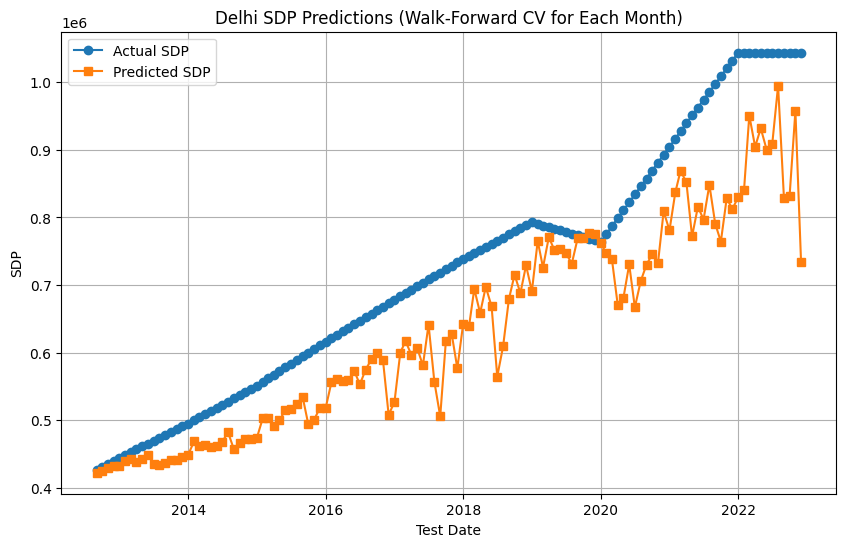

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Ensure the 'date' column is in datetime format and sort the DataFrame.
# Here we assume that 'date_y' contains the date information.
merged_df['date'] = pd.to_datetime(merged_df['date_y'])
merged_df = merged_df.sort_values('date')

# Create a numeric month column if not already present.
merged_df['month_int'] = merged_df['month']

# Define feature columns (including the month as a seasonal feature)
feature_columns = [
    'light_sum', 'light_mean', 'light_std', 'light_max',
    'urban_area_ratio', 'brightness_urban', 'light_entropy',
    'light_contrast', 'light_energy', 'month_int'
]

results = []

# Select test dates: use every month from 2011 to 2022.
test_dates = merged_df[(merged_df['year'] >= 2011) & (
    merged_df['year'] <= 2022)]['date'].unique()
test_dates = np.sort(test_dates)

for test_date in test_dates:
    # Training set: all data strictly before the test date.
    train_data = merged_df[merged_df['date'] < test_date]
    # Test set: data exactly on the test date.
    test_data = merged_df[merged_df['date'] == test_date]

    if train_data.empty or test_data.empty:
        print(
            f"Insufficient data for test date {pd.to_datetime(test_date).date()}. Skipping.")
        continue

    # Prepare features and target (SDP is your target variable)
    X_train = train_data[feature_columns].values
    y_train = train_data['SDP'].values
    X_test = test_data[feature_columns].values
    y_test = test_data['SDP'].values

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set for the current month
    y_pred = rf_model.predict(X_test_scaled)
    # Average in case multiple images exist on the same date
    predicted = np.mean(y_pred)
    actual = np.mean(y_test)
    error = (predicted - actual) / actual

    results.append({
        'test_date': test_date,
        'actual_sdp': actual,
        'predicted_sdp': predicted,
        'error': error,
        'num_train_samples': len(train_data),
        'num_test_samples': len(test_data)
    })
    print(f"Test date {pd.to_datetime(test_date).date()}: Predicted SDP = {predicted:.2f}, Actual SDP = {actual:.2f}, Error = {error:.2f}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print("\nWalk-Forward Cross Validation Results:")
print(results_df)

# Plot predicted vs. actual SDP values over the test dates
plt.figure(figsize=(10, 6))
plt.plot(results_df['test_date'], results_df['actual_sdp'],
         marker='o', label='Actual SDP')
plt.plot(results_df['test_date'], results_df['predicted_sdp'],
         marker='s', label='Predicted SDP')
plt.xlabel('Test Date')
plt.ylabel('SDP')
plt.title('Delhi SDP Predictions (Walk-Forward CV for Each Month)')
plt.legend()
plt.grid(True)
plt.show()

<AxesSubplot:>

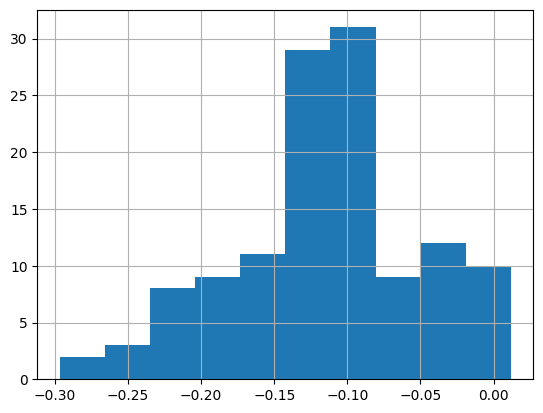

In [56]:
results_df['error'].hist()

In [60]:
results_df.test_date.unique()

array(['2012-09-01T00:00:00.000000000', '2012-10-01T00:00:00.000000000',
       '2012-11-01T00:00:00.000000000', '2012-12-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000', '2013-02-01T00:00:00.000000000',
       '2013-03-01T00:00:00.000000000', '2013-04-01T00:00:00.000000000',
       '2013-05-01T00:00:00.000000000', '2013-06-01T00:00:00.000000000',
       '2013-07-01T00:00:00.000000000', '2013-08-01T00:00:00.000000000',
       '2013-09-01T00:00:00.000000000', '2013-10-01T00:00:00.000000000',
       '2013-11-01T00:00:00.000000000', '2013-12-01T00:00:00.000000000',
       '2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
       '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
       '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
       '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
       '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01

Mean relative error: -0.115, calibration factor: 1.130

Updated Error Statistics After Calibration:
count    1.240000e+02
mean    -2.730791e-17
std      7.210058e-02
min     -2.052560e-01
25%     -3.498440e-02
50%      4.374556e-03
75%      3.782974e-02
max      1.432235e-01
Name: error_calibrated, dtype: float64


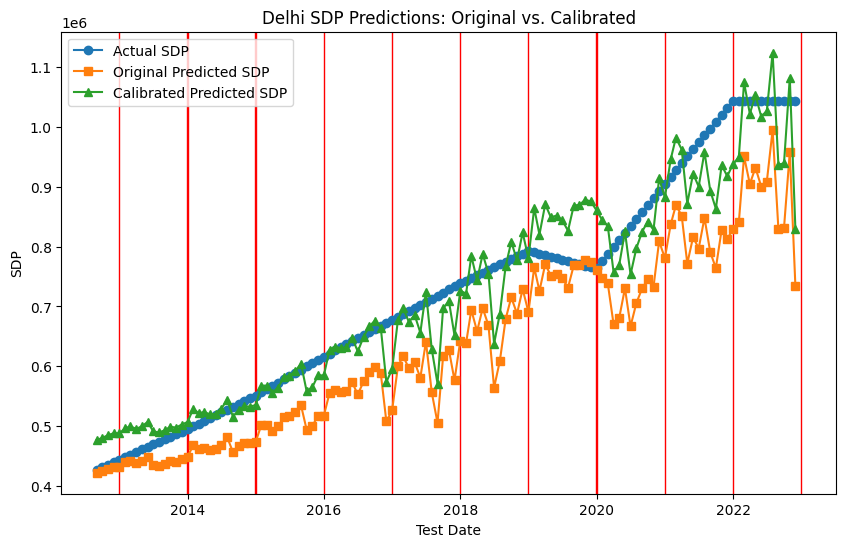

In [64]:
# Calculate the calibration factor based on the average relative error.
mean_error = results_df['error'].mean()  # e.g., -0.114942
# for -0.115, factor ≈ 1 / 0.885 ≈ 1.13
calibration_factor = 1 / (1 + mean_error)

print(
    f"Mean relative error: {mean_error:.3f}, calibration factor: {calibration_factor:.3f}")

# Apply calibration to each predicted SDP in the results DataFrame.
results_df['predicted_sdp_calibrated'] = results_df['predicted_sdp'] * \
    calibration_factor

# Calculate the new relative error after calibration.
results_df['error_calibrated'] = (
    results_df['predicted_sdp_calibrated'] - results_df['actual_sdp']) / results_df['actual_sdp']

# Print updated error statistics.
print("\nUpdated Error Statistics After Calibration:")
print(results_df['error_calibrated'].describe())

# Plot both the original and calibrated predictions.
plt.figure(figsize=(10, 6))
plt.plot(results_df['test_date'], results_df['actual_sdp'],
         marker='o', label='Actual SDP')
plt.plot(results_df['test_date'], results_df['predicted_sdp'],
         marker='s', label='Original Predicted SDP')
plt.plot(results_df['test_date'], results_df['predicted_sdp_calibrated'],
         marker='^', label='Calibrated Predicted SDP')
years_unique = pd.DatetimeIndex(results_df['test_date']).year.unique()
for year in years_unique:
    start = pd.Timestamp(year=year, month=12, day=31)
    end = pd.Timestamp(year=year+1, month=1, day=1)
    # Use a light shading (alpha) to highlight the year.
    plt.axvspan(start, end, color='red', alpha=1)
plt.xlabel('Test Date')
plt.ylabel('SDP')
plt.title('Delhi SDP Predictions: Original vs. Calibrated')
plt.legend()
# plt.grid(True)
plt.show()

Test date 2013-06-01: Predicted SDP = 448611.03, Actual SDP = 465144.58, Error = -0.04
Test date 2014-06-01: Predicted SDP = 460920.35, Actual SDP = 518136.75, Error = -0.11
Test date 2015-06-01: Predicted SDP = 514821.04, Actual SDP = 578004.42, Error = -0.11
Test date 2016-06-01: Predicted SDP = 572939.17, Actual SDP = 641841.25, Error = -0.11
Test date 2017-06-01: Predicted SDP = 580799.14, Actual SDP = 703103.75, Error = -0.17
Test date 2018-06-01: Predicted SDP = 668240.63, Actual SDP = 761106.50, Error = -0.12
Test date 2019-06-01: Predicted SDP = 753918.19, Actual SDP = 780629.33, Error = -0.03
Test date 2020-06-01: Predicted SDP = 730413.21, Actual SDP = 822271.25, Error = -0.11
Test date 2021-06-01: Predicted SDP = 815940.73, Actual SDP = 962607.42, Error = -0.15
Test date 2022-06-01: Predicted SDP = 900383.16, Actual SDP = 1043759.00, Error = -0.14

Walk-Forward Cross Validation Results:
   test_date    actual_sdp  predicted_sdp     error  num_train_samples  \
0 2013-06-01  4

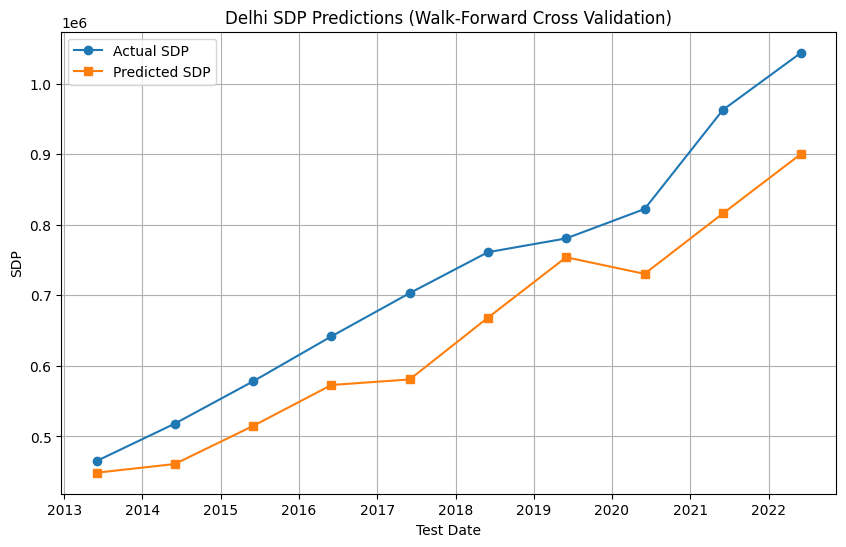

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Ensure the 'date' column is in datetime format and sorted.
# (Adjust if necessary: here we're converting 'date_y' to datetime.)
merged_df['date'] = pd.to_datetime(merged_df['date_y'])
merged_df = merged_df.sort_values('date')

# Create a numeric month column if not already present.
merged_df['month_int'] = merged_df['month']

# Define feature columns (including the month as an extra seasonal feature)
feature_columns = [
    'light_sum', 'light_mean', 'light_std', 'light_max',
    'urban_area_ratio', 'brightness_urban', 'light_entropy',
    'light_contrast', 'light_energy', 'month_int'
]

results = []

# Identify test dates: choose only the June images up to year 2022 (since 2023 SDP data is unavailable).
test_dates = merged_df[(merged_df['month'] == 6) & (
    merged_df['year'] <= 2022)]['date'].unique()
test_dates = np.sort(test_dates)

for test_date in test_dates:
    # Training set: all data strictly before the test date.
    train_data = merged_df[merged_df['date'] < test_date]
    # Test set: data exactly on the test date.
    test_data = merged_df[merged_df['date'] == test_date]

    if train_data.empty or test_data.empty:
        print(f"Insufficient data for test date {test_date}. Skipping.")
        continue

    # Prepare features and target (SDP is your target variable)
    X_train = train_data[feature_columns].values
    y_train = train_data['SDP'].values
    X_test = test_data[feature_columns].values
    y_test = test_data['SDP'].values

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test_scaled)
    # In case there are multiple images on the test date.
    predicted = np.mean(y_pred)
    actual = np.mean(y_test)
    error = (predicted - actual) / actual

    results.append({
        'test_date': test_date,
        'actual_sdp': actual,
        'predicted_sdp': predicted,
        'error': error,
        'num_train_samples': len(train_data),
        'num_test_samples': len(test_data)
    })
    print(
        f"Test date {pd.to_datetime(test_date).date()}: Predicted SDP = {predicted:.2f}, Actual SDP = {actual:.2f}, Error = {error:.2f}"
    )

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print("\nWalk-Forward Cross Validation Results:")
print(results_df)

# Plot predicted vs. actual SDP values over the test dates
plt.figure(figsize=(10, 6))
plt.plot(results_df['test_date'], results_df['actual_sdp'],
         marker='o', label='Actual SDP')
plt.plot(results_df['test_date'], results_df['predicted_sdp'],
         marker='s', label='Predicted SDP')
plt.xlabel('Test Date')
plt.ylabel('SDP')
plt.title('Delhi SDP Predictions (Walk-Forward Cross Validation)')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
pd.DataFrame(results)['error'].mean()

-0.024291193276460312

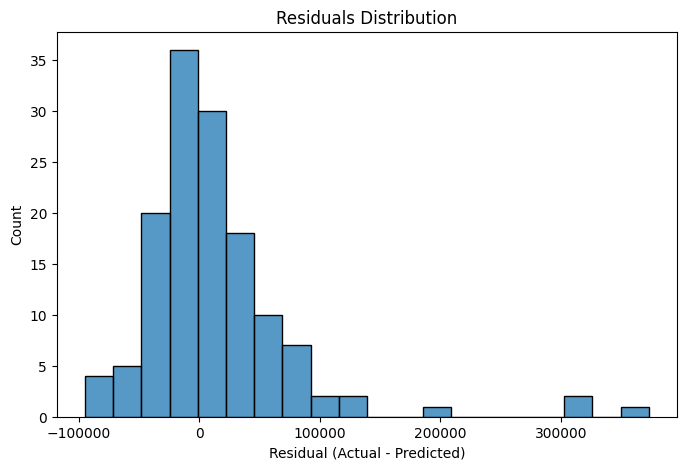

In [52]:
import seaborn as sns

residuals = merged_df['SDP'] - \
    rf_model.predict(scaler.transform(merged_df[feature_columns].values))
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=20)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

In [53]:
residuals.describe()

count       138.000000
mean      13361.815930
std       65121.902568
min      -94755.637833
25%      -20728.932250
50%        1015.111500
75%       32310.495083
max      372901.613667
Name: SDP, dtype: float64